## Uniform Time Course process output comparisons

In [1]:
import sys
import os
from tempfile import mkdtemp

import numpy as np
from process_bigraph import Composite
from process_bigraph.experiments.parameter_scan import RunProcess


sys.path.insert(0, '..')


from biosimulator_processes.processes.amici_process import UtcAmici
from biosimulator_processes.processes.copasi_process import UtcCopasi

from biosimulator_processes.io import read_report_outputs
from biosimulator_processes.helpers import plot_utc_outputs, plot_ode_output_data

Smoldyn is not properly installed in this environment and thus its process implementation cannot be registered. Please consult smoldyn documentation.
Available processes:
[ 'console-emitter',
  'ram-emitter',
  'composite',
  'cobra-process',
  'copasi-process',
  'tellurium-process',
  'utc-amici',
  'utc-copasi',
  'copasi-step',
  'tellurium-step',
  'amici-step',
  'plotter',
  'plotter2d']


In [2]:
omex_dir = '../test_suite/examples/sbml-core/Elowitz-Nature-2000-Repressilator'
omex_fp = omex_dir + '.omex'
sbml_fp = os.path.join(omex_dir, 'BIOMD0000000012_url.xml')
sedml_fp = os.path.join(omex_dir, 'simulation.sedml')
reports_path = os.path.join(omex_dir, 'reports.h5')

Configure and create an Amici UTC instance using just the archive filepath.

In [3]:
utc_amici = UtcAmici(config={'model': {'model_source': omex_dir + '.omex'}})

2024-05-30 16:38:50.779 - amici.sbml_import - INFO - Finished importing SBML                         (4.40E-02s)
2024-05-30 16:38:50.829 - amici.sbml_import - INFO - Finished processing SBML observables            (4.61E-02s)
2024-05-30 16:38:50.836 - amici.sbml_import - INFO - Finished processing SBML event observables      (1.08E-06s)
2024-05-30 16:38:50.861 - amici.de_model - INFO - Finished computing xdot                            (3.83E-03s)
2024-05-30 16:38:50.869 - amici.de_model - INFO - Finished computing x0                              (3.03E-03s)
2024-05-30 16:38:50.888 - amici.de_model - INFO - Finished computing w                               (1.59E-02s)
2024-05-30 16:38:51.607 - amici.de_export - INFO - Finished generating cpp code                      (7.13E-01s)
2024-05-30 16:39:00.710 - amici.de_export - INFO - Finished compiling cpp code                       (9.10E+00s)


In [4]:
# t range parameters set via sedml introspection within archive contents:
utc_amici.t[0], utc_amici.t[-1], utc_amici.duration, utc_amici.step_size, utc_amici.num_steps

(400.0, 1000.0, 1000, 1.0, 601)

In [5]:
# you can verify this time config against the SEDML file
!cat ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml

cat: ./examples/sbml-core/Elowitz-Nature-2000-Repressilator/simulation.sedml: No such file or directory


In [6]:
# run the amici utc simulation with the interface's update method:
amici_results = utc_amici.update()

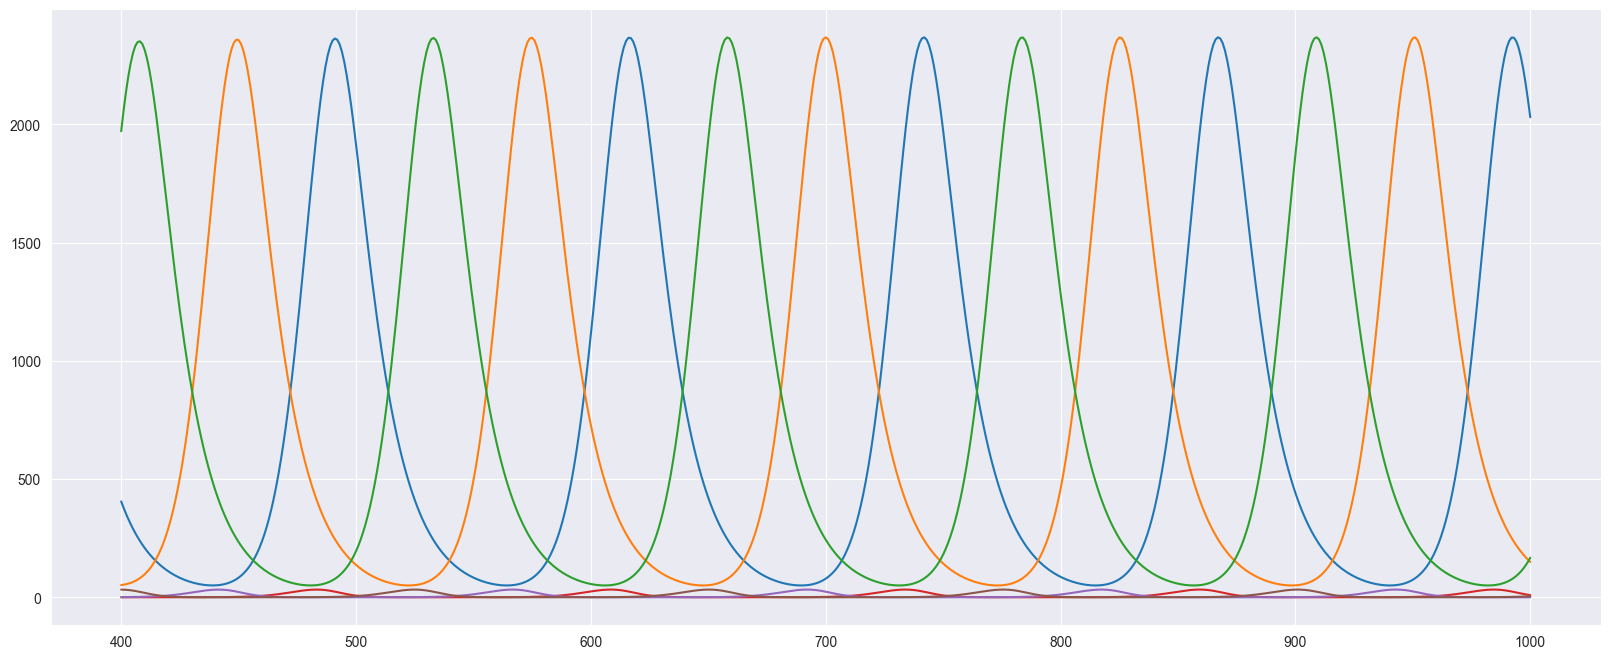

In [7]:
# use built-in plot to plot results
utc_amici.plot_results()

Create a `UtcTellurium` instance as above

In [8]:
from biosimulator_processes.processes.tellurium_process import UtcTellurium


utc_tellurium = UtcTellurium(config={'model': {'model_source': omex_dir + '.omex'}})

In [9]:
tellurium_results = utc_tellurium.update()

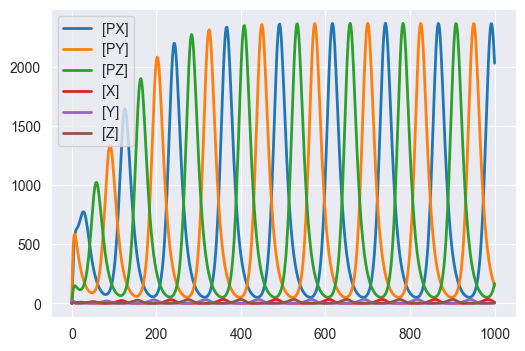

In [10]:
utc_tellurium.plot_results()

Create a `UtcCopasi` instance and run the same

In [11]:
utc_copasi = UtcCopasi(config={'model': {'model_source': omex_dir + '.omex'}})

In [12]:
copasi_results = utc_copasi.update()

<Axes: xlabel='Time'>

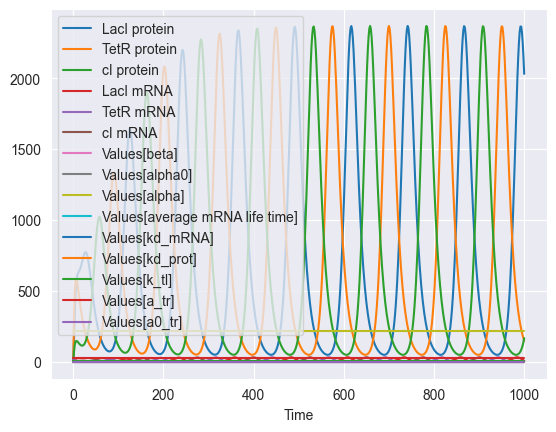

In [13]:
utc_copasi.plot_results()

Finally, optionally generate a "ground truth" which we include in the comparison. The default source for ground-truth data is via uploading an omex archive as model source. The report outputs must be included in the archive.

In [14]:
# Generate comparison matrix from ground truth
from biosimulator_processes.api.compare import write_utc_comparison_reports
from biosimulator_processes.io import standardize_report_outputs

In [15]:
report_results = standardize_report_outputs(reports_path)

In [16]:
print(f"copasi result keys: {copasi_results['floating_species'].keys()}\nTellurium result keys: {tellurium_results['floating_species'].keys()}\nAmici Result keys: {amici_results['floating_species'].keys()}\nGround truth report keys: {report_results['floating_species'].keys()}")

copasi result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Tellurium result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Amici Result keys: dict_keys(['PX', 'PY', 'PZ', 'X', 'Y', 'Z'])
Ground truth report keys: dict_keys(['LacI protein', 'TetR protein', 'cI protein', 'LacI mRNA', 'TetR mRNA', 'cI mRNA'])


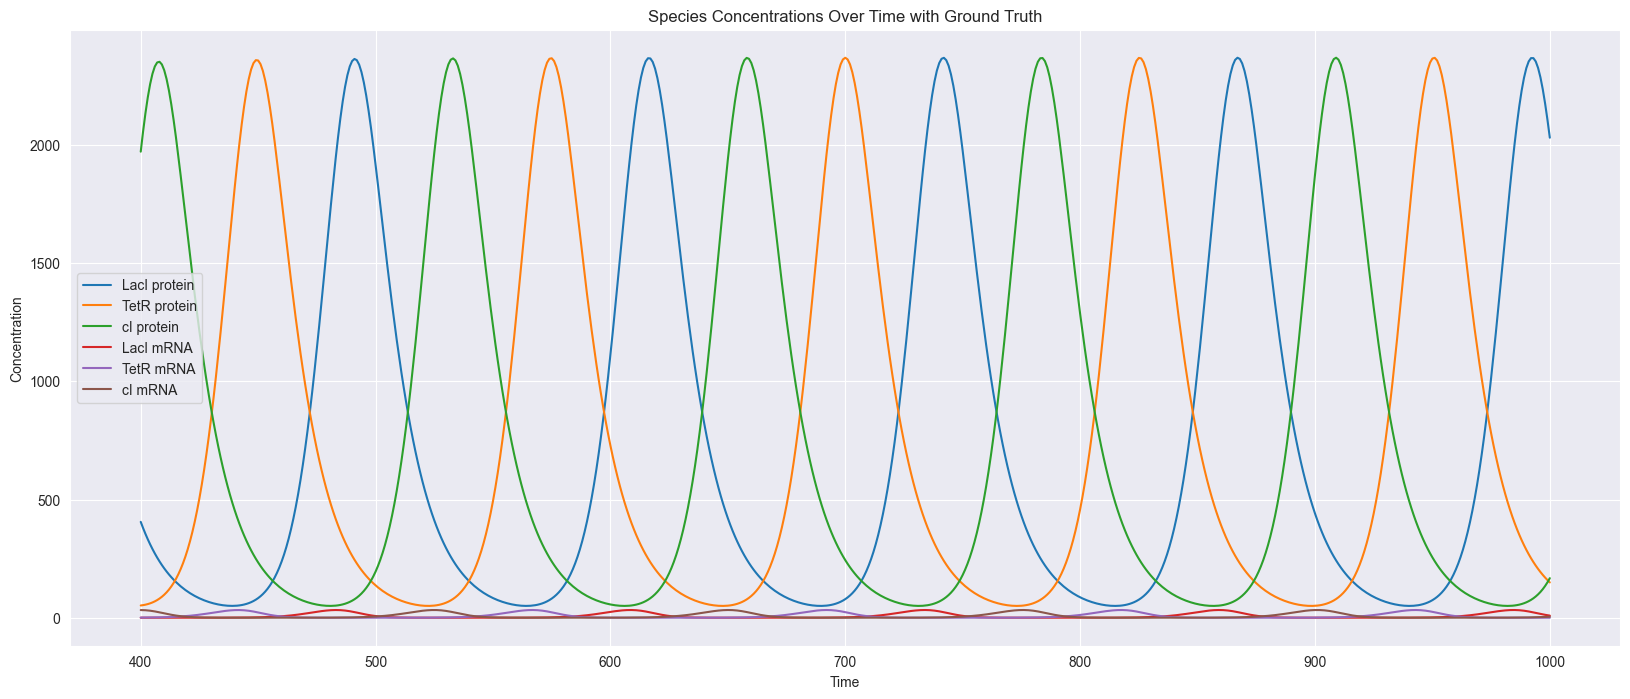

In [17]:
plot_ode_output_data(report_results, simulator_name='Ground Truth')

Generate a series of comparisons for each species and save to a given dir

In [18]:
write_utc_comparison_reports(
    save_dir='../test_outputs/repressilator-utc-comparison',
    copasi_results=copasi_results,
    tellurium_results=tellurium_results,
    amici_results=amici_results,
    ground_truth_results=report_results,
    sbml_species_mapping=utc_copasi.sbml_species_mapping,
    method='mse')

In [19]:
import numpy as np 

initial = 0
outStart = 400
duration = 1000
n_steps = 601
x = np.linspace(initial, duration, duration)
y = np.stack([x, x, x])

In [20]:
from biosimulator_processes.api.results import infer_slice

In [21]:
x[0]

0.0

In [46]:
slice_params = infer_slice(x, outStart)

slice_params[0]

399

In [23]:
len(utc_copasi.floating_species_list)

6

In [24]:
np.array(list(copasi_results['floating_species'].values()))[:, slice_params[0]:slice_params[1]].shape

(6, 202)

In [25]:
np.array(list(report_results['floating_species'].values()))[:, slice_params[0]:slice_params[1]].shape

(6, 202)

In [26]:
report_results['floating_species']['cI mRNA']

array([32.52388898, 32.30245358, 31.77728115, 30.94640665, 29.81831626,
       28.4131422 , 26.76300939, 24.91122098, 22.91010753, 20.81765891,
       18.6933613 , 16.59387179, 14.56920852, 12.65997761, 10.89597765,
        9.29596009,  7.86859572,  6.61403763,  5.52585445,  4.5929717 ,
        3.80143763,  3.13589182,  2.58068731,  2.1207008 ,  1.74185497,
        1.43141675,  1.17812645,  0.97220604,  0.80529023,  0.67030987,
        0.56135239,  0.47351528,  0.40276329,  0.34579559,  0.29992602,
        0.26297863,  0.23319721,  0.20916868,  0.18975916,  0.17406069,
        0.16134763,  0.15104092,  0.14267917,  0.13589528,  0.13039767,
        0.12595524,  0.12238536,  0.11954439,  0.11732006,  0.11562558,
        0.11439493,  0.11357921,  0.11314388,  0.11306659,  0.11333561,
        0.11394879,  0.11491275,  0.11624253,  0.11796142,  0.12010114,
        0.1227021 ,  0.12581405,  0.12949674,  0.13382098,  0.13886977,
        0.14473973,  0.15154275,  0.15940798,  0.16848403,  0.17

In [27]:
data = np.array([output[int(outStart/2 - 200):duration] for output in copasi_results['floating_species'].values()])
t = copasi_results['time'][int(outStart/2 - 200):duration]
data.shape, t.shape

((6, 601), (600,))

In [28]:
report_results_data = np.array([output for output in copasi_results['floating_species'].values()])
report_results_data.shape

(6, 601)

<Axes: >

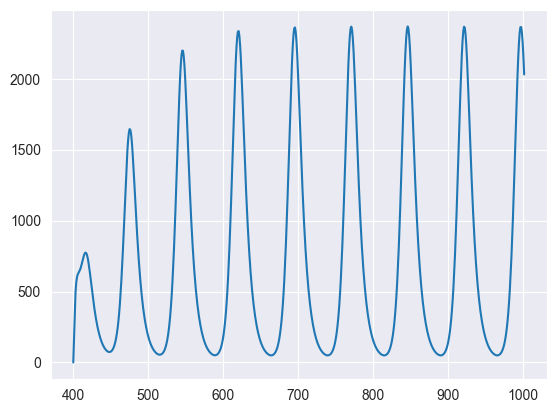

In [29]:
import seaborn as sns 

t = t.tolist()
t.append(1001.0)
t = np.array(t)
sns.lineplot(x=t, y=data[0])

In [30]:
t.shape, data[0].shape

((601,), (601,))

In [55]:
data = np.array([output[outStart:1000] for output in copasi_results['floating_species'].values()])

In [56]:
data.shape

(6, 201)

In [53]:
data.shape

(6, 1)